In [1]:
# Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from warnings import filterwarnings


In [2]:
# install IMBlearn package 
#!pip install imblearn

In [3]:
# install xgboost
#!pip install xgboost

Note: Delete the "**#**" in "**pip install imblearn**" if you haven't installed imblearn module in your python environment.

Load Data

In [4]:
# Load csv data
data = pd.read_csv("water_potability.csv")
data

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [5]:
# Check data shape
data.shape

(3276, 10)

### **1. Data Preparation & Cleaning** 

#### **Data Validation**

In [6]:
# Check data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


- Data types in each column are valid, no mismtached data types
- All variable are numerical

#### **Check missing values and duplicate data**

In [7]:
# check missing values, sorted from highest 
print("Missing values proportion:")
print(data.isna().sum().sort_values(ascending = False)/data.shape[0]*100)

# Check duplicates
print("="*50)
print(f'Duplicate data: {data.duplicated().any()}')

Missing values proportion:
Sulfate            23.840049
ph                 14.987790
Trihalomethanes     4.945055
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Conductivity        0.000000
Organic_carbon      0.000000
Turbidity           0.000000
Potability          0.000000
dtype: float64
Duplicate data: False


There are 3 columns with missing values: Sulfate, ph and Trihalomethanes. No duplicate data

In [8]:
data_dropped = data.dropna() # drop missing values

# Check total data loss percentage if missing values are dropped
loss = 100 - (data_dropped.shape[0]/data.shape[0])*100 

print("Percentage data loss:")
print(f"{np.round(loss,3)} %")

Percentage data loss:
38.614 %


- Because ~38% data will be lost if we drop missing values, we'll fill the missing values with imputation method in Data Preprocessing later
- Imputation will be done after Train-Test split to avoid data leakage

In [9]:
# Check the data again
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [10]:
# Check basic statistical description
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


Karena range nilai data di beberapa variabel jauh berbeda dengan variabel lain, maka perlu dilakukan standarisasi dengan StandardScaler

### **2. Data Preprocessing** 

#### **Input - Output Split**

Split the data with Potability as Output/target, the rest as Input/predictor

In [11]:
# Split input-output 
X = data.drop(columns = "Potability")
y = data["Potability"]

In [12]:
# check input 
X.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075


In [13]:
# check output
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Potability, dtype: int64

#### **Train-Validation-Test Split**

Split the data into 70:30 ratio for **Train-Test**

In [14]:
# Import split from sklearn
from sklearn.model_selection import train_test_split

In [15]:
# Split data into Train - Test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [16]:
# Sanity check 
print(x_train.shape)
print(x_test.shape)

(2293, 9)
(983, 9)


Split again Test data to get a **Validation** set, 50:50 ratio

In [17]:
# Split Train data into Train - Validation set
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 42, stratify = y_test)

In [18]:
# Sanity check 
print(x_valid.shape)
print(x_test.shape)

(491, 9)
(492, 9)


#### **Impute missing values**

In [19]:
# Check % missing values in train data
print("Missing values proportion:")
print(x_train.isna().sum().sort_values(ascending = False)/data.shape[0])

Missing values proportion:
Sulfate            0.167582
ph                 0.105006
Trihalomethanes    0.035409
Hardness           0.000000
Solids             0.000000
Chloramines        0.000000
Conductivity       0.000000
Organic_carbon     0.000000
Turbidity          0.000000
dtype: float64


In [20]:
# Columns with missing values
missing_column= ["ph", "Sulfate", "Trihalomethanes"]

# Impute with median
for columns in missing_column:
    median = x_train[columns].median()
    x_train[columns].fillna(median,inplace=True)

In [21]:
# Check missing values after imputation
x_train.isna().any()

ph                 False
Hardness           False
Solids             False
Chloramines        False
Sulfate            False
Conductivity       False
Organic_carbon     False
Trihalomethanes    False
Turbidity          False
dtype: bool

No more missing values in Train data after imputation

In [22]:
# Impute function
def imputationMedian(data, column_with_null):

    for columns in column_with_null:
        median_value = data[columns].median()
        data[columns].fillna(median_value, inplace = True)

    return data


Impute data in Test and Validation set

In [23]:
# Impute in Test set
x_test_impute = imputationMedian(x_test, missing_column)

# Impute in Validation set
x_valid_impute = imputationMedian(x_valid, missing_column)

In [24]:
# check imputation result
x_test.isna().any()

ph                 False
Hardness           False
Solids             False
Chloramines        False
Sulfate            False
Conductivity       False
Organic_carbon     False
Trihalomethanes    False
Turbidity          False
dtype: bool

In [25]:
# check imputation result
x_valid.isna().any()

ph                 False
Hardness           False
Solids             False
Chloramines        False
Sulfate            False
Conductivity       False
Organic_carbon     False
Trihalomethanes    False
Turbidity          False
dtype: bool

Missing values in Test and Validation set now have been imputed with their respective median

#### **Standardizing data**

In [26]:
# Import Scaler from sklearn
from sklearn.preprocessing import StandardScaler

In [27]:
# Standard scaler function
def scaler_transform(X, scaler = None):
    """
    Fungsi untuk melakukan standardisasi
    :param X: <pandas DataFrame> sampel data
    :param scaler: <sklearn object> scaler, default None
    :return X_scaled: <pandas Dataframe> sampel data OHE
    :param scaler: <sklearn object> scaler, default None
    """
    if scaler != None:
        pass
    else:
        # Buat & fit encoder
        scaler = StandardScaler()
        scaler.fit(X)

    # Tranform data
    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled,
                            columns = X.columns,
                            index = X.index)
    
    return X_scaled, scaler


In [28]:
# Scaling Train data
x_train_clean, scaler = scaler_transform(X = x_train)

In [29]:
x_train.head(3)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
2018,7.031684,237.083948,35434.280062,7.617649,381.337527,365.032503,13.453872,33.439868,3.825937
2740,6.789821,197.300014,22527.681207,5.166942,399.981755,422.482029,15.916605,47.935105,4.512068
2746,5.636924,159.139410,27283.780655,6.918727,328.907287,317.830981,13.611408,36.335199,3.007138


In [30]:
x_train_clean.head(3)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
2018,-0.035674,1.237015,1.550126,0.324340,1.304856,-0.776008,-0.247820,-2.070895,-0.185324
2740,-0.200338,0.017734,0.081184,-1.202600,1.816863,-0.067932,0.505598,-1.152280,0.692067
2746,-0.985247,-1.151796,0.622491,-0.111131,-0.134983,-1.357775,-0.199626,-1.887408,-1.232364


In [31]:
# Scaling test and validation data
x_test_clean, scaler = scaler_transform(X = x_test)

x_valid_clean, scaler = scaler_transform(X = x_valid)

In [32]:
x_test_clean.head(3)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
160,-0.000621,1.503628,-0.310828,1.045218,-0.041799,0.219244,0.637657,-0.131883,-0.233559
1067,-0.000621,0.587566,0.096845,1.709769,1.421283,-0.621837,1.326157,-0.478159,0.537095
3070,-0.000621,0.574936,-0.154073,0.110978,-0.790681,-1.829574,0.234458,2.465344,-0.131067


In [33]:
x_valid_clean.head(3)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
1205,-1.811385,1.877846,-1.580365,1.193226,-0.017864,0.114231,0.618712,0.001374,0.433179
2285,-0.006669,1.270897,1.360558,-1.482844,0.796206,1.486361,1.439262,1.276686,-0.228583
1177,-1.097549,0.075253,-0.381316,-1.458139,-1.081870,-0.970489,1.329499,0.570689,0.658335


### **3. Data Exploration (EDA)**

In [34]:
# Concat X_train and Y_train for EDA purposes
eda_train = pd.concat([x_train_clean, y_train], axis = 1)
eda_train.head(3)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
2018,-0.035674,1.237015,1.550126,0.324340,1.304856,-0.776008,-0.247820,-2.070895,-0.185324,1
2740,-0.200338,0.017734,0.081184,-1.202600,1.816863,-0.067932,0.505598,-1.152280,0.692067,1
2746,-0.985247,-1.151796,0.622491,-0.111131,-0.134983,-1.357775,-0.199626,-1.887408,-1.232364,1


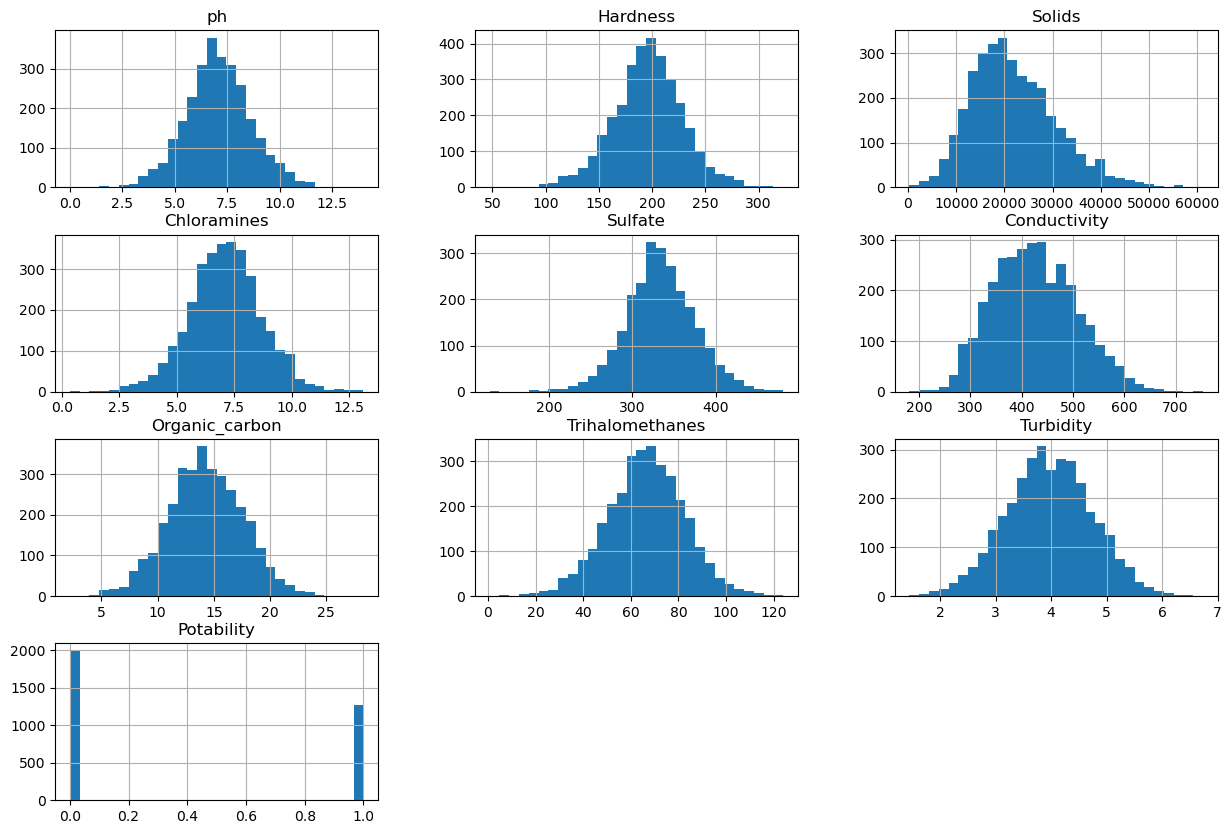

In [35]:
# Distribution in each variables
data.hist(bins=30, figsize=(15, 10))
plt.show()

Data tiap variabel cenderung berdistribusi **normal**

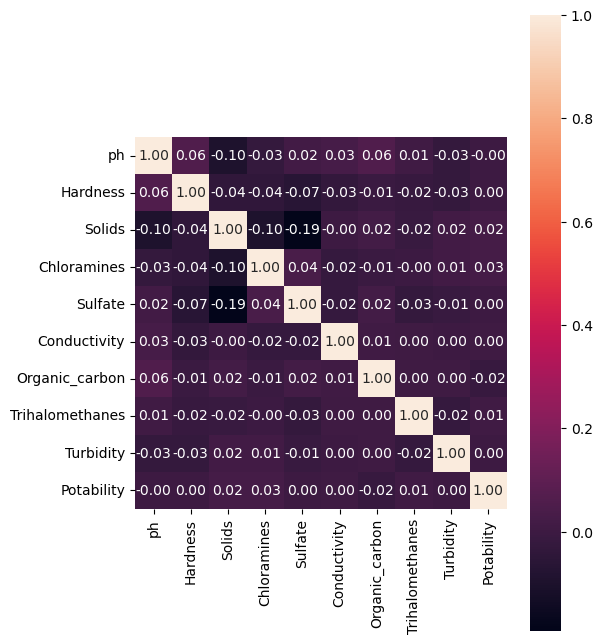

In [36]:
# Correlation heatmap
plt.figure(figsize = (6,8))
sns.heatmap(eda_train.corr(), fmt= ".2f", annot= True,square= True)
plt.show()

From the heatmap, we can conclude that all of the variables have **very weak correlation** with Potability

[Text(0, 0, '1398'), Text(0, 0, '895')]

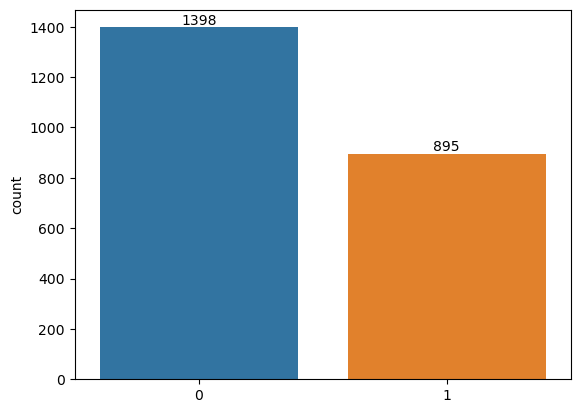

In [37]:
# Check distribution of our label data
ax = sns.countplot(data = y_train, x = y_train.values, label = y_train.unique())
ax.bar_label(ax.containers[0])

- There's some imbalance in our label data, potable(1) data are less than non-potable water (0)
- 1398 data for Non-potable water and 895 data for Potable water
- Balance the data with **oversampling** method 

First, we import RandomOversampler from imblearn library

In [38]:
# Import os from imblearn
from imblearn.over_sampling import RandomOverSampler

In [39]:
# Buat objek
smt = RandomOverSampler(random_state = 123)

# Fit objek
x_train_os, y_train_os = smt.fit_resample(x_train_clean, y_train)

In [40]:
y_train_os.value_counts()

1    1398
0    1398
Name: Potability, dtype: int64

The data is balanced after oversampling

### **4. Modelling Process**

Check the risks:
- Wrong Potable prediction:
    - Can get sick because pathogens or dangerous substance
    - Healthcare costs

- Wrong Non-potable prediction:
    - Need to find another water source

If potable = 1, non-potable = 0, then we need to Precision as our metric (decrease False Positive)


In [41]:
# Model performance & evalutaion libraries
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score,accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn import metrics

# Hyperparameter
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,RepeatedStratifiedKFold

#### **Baseline**

Because this is a classification model, **mode** will be used as baseline

In [42]:
y_train_os.value_counts(normalize = True)

1    0.5
0    0.5
Name: Potability, dtype: float64

In the balanced Train data, the **baseline accuracy is 50%** because we use oversampling

#### **Try several models**



We will train 6 models and check the score in Validation set to find the top performing model/s

In [43]:
# Model library 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [44]:
# store models to a list

models =[("Logistic Regression", LogisticRegression(max_iter=500)),
        ('KNN',KNeighborsClassifier(n_neighbors=10)),
        ('RandomForest',RandomForestClassifier(random_state = 123)),
        ('Naive Bayes', GaussianNB()),
        ('SVM', SVC()),
        ('XGBoost', XGBClassifier())
        ]

# List for storing model score results
precision_result = []
acc_result = []
model_names = []

# Anti duplicate 
prec_seen = set(precision_result)
acc_seen = set(acc_result)
name_seen = set(model_names)


Model training 

Model training and result in balanced data

In [45]:
filterwarnings('ignore')

# Clear the list for retraining model
model_names.clear()
precision_result.clear()
acc_result.clear()
name_seen.clear()
prec_seen.clear()
acc_seen.clear()

# For loop to train several models and show results
for name, model in models:

    # Fit model
    model.fit(x_train_os, y_train_os)
    y_pred_val = model.predict(x_valid_clean)
    score = precision_score(y_valid, y_pred_val, average ='macro')
    acc_score = accuracy_score(y_valid, y_pred_val)

    # store to list
    if score not in prec_seen:
        prec_seen.add(score)
        precision_result.append(score)

    acc_result.append(acc_score)    

    if name not in name_seen:
        name_seen.add(name)
        model_names.append(name)

    # print classification report
    print(f'Model: {name}')
    print(classification_report(y_valid,
                                y_pred_val,
                                target_names = ["non-potable (0)", "potable (1)"]))

Model: Logistic Regression
                 precision    recall  f1-score   support

non-potable (0)       0.65      0.54      0.59       300
    potable (1)       0.43      0.53      0.47       191

       accuracy                           0.54       491
      macro avg       0.54      0.54      0.53       491
   weighted avg       0.56      0.54      0.55       491

Model: KNN
                 precision    recall  f1-score   support

non-potable (0)       0.68      0.78      0.73       300
    potable (1)       0.55      0.42      0.48       191

       accuracy                           0.64       491
      macro avg       0.62      0.60      0.60       491
   weighted avg       0.63      0.64      0.63       491



Model: RandomForest
                 precision    recall  f1-score   support

non-potable (0)       0.68      0.83      0.75       300
    potable (1)       0.59      0.39      0.47       191

       accuracy                           0.66       491
      macro avg       0.63      0.61      0.61       491
   weighted avg       0.64      0.66      0.64       491

Model: Naive Bayes
                 precision    recall  f1-score   support

non-potable (0)       0.64      0.69      0.67       300
    potable (1)       0.45      0.40      0.43       191

       accuracy                           0.58       491
      macro avg       0.55      0.55      0.55       491
   weighted avg       0.57      0.58      0.57       491

Model: SVM
                 precision    recall  f1-score   support

non-potable (0)       0.69      0.69      0.69       300
    potable (1)       0.52      0.52      0.52       191

       accuracy                           0.63       491
      macro avg       0.61    

Training Result - Validation Set

In [46]:
# make result into tables
precision_table = pd.DataFrame({'Model': model_names, 'Precision': precision_result, 'Accuracy': acc_result})
precision_table.sort_values(by = 'Precision', ascending = False)

,Model,Precision,Accuracy
2,RandomForest,0.633377,0.655804
1,KNN,0.615457,0.641548
4,SVM,0.605829,0.625255
5,XGBoost,0.601984,0.629328
3,Naive Bayes,0.548900,0.578411
0,Logistic Regression,0.536802,0.539715


- We can see the top performing models are **Random Forest and KNN** based on **Precision**
- SVM and XGboost is the 3rd and 4th best with very minimal score difference
- So we will fine tune KNN and Random Forest as top 2 model



#### **Hyperparameter Tuning**

In [47]:
# Function to evaluate model
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)

    precision = precision_score (test_labels, predictions, average = 'macro')
    accuracy = accuracy_score (test_labels, predictions)

    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('Precision = {:0.2f}%.'.format(precision))
    print('')
    
    return precision

1. K-Nearest Neighbor

In [48]:
# KNN 
knn = KNeighborsClassifier(n_neighbors= 10)

# parameters
params = { 'n_neighbors' : np.arange(0, 51),
               'weights' : ['uniform','distance'],
               'metric' : ['euclidean','manhattan']}

In [49]:
# Tuning KNN
knn_cv = GridSearchCV(knn, param_grid = params, cv=10, scoring = 'precision', n_jobs = -1)

In [50]:
#Fit tuned model
knn_cv.fit(x_train_os, y_train_os)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_neighbors=10), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
                         'weights': ['uniform', 'distance']},
             scoring='precision')

In [51]:
print(knn_cv.best_estimator_)

KNeighborsClassifier(metric='manhattan', n_neighbors=50, weights='distance')


In [52]:
# Base model
knn_base = knn
knn_base.fit(x_train_os, y_train_os)
knn_base_result = evaluate (knn_base, x_valid_clean, y_valid)

print("----After hyperparameter tuning----")
print("")

# Tuned model
knn_tuned = knn_cv.best_estimator_
knn_tuned_result = evaluate(knn_tuned, x_valid_clean, y_valid)


# Improvement from base
print('Precision Score improvement: {:0.2f}%.'.format( 100 * (knn_tuned_result - knn_base_result) / knn_base_result))


Model Performance
Average Error: 0.3585 degrees.
Accuracy = 0.64%.
Precision = 0.62%.

----After hyperparameter tuning----

Model Performance
Average Error: 0.3625 degrees.
Accuracy = 0.64%.
Precision = 0.61%.

Precision Score improvement: -0.12%.


After hyperparameter tuning, precision **decreased by -0.12%**

2. Random Forest

In [53]:
# Random Forest
rf_tree = RandomForestClassifier(random_state = 123)

# parameters
params = {
    'n_estimators': [100,200,500, 700],
    'max_features': ['sqrt', 'log2', 'auto'],
    'min_samples_leaf': [2, 3, 4, 5, 10, 15, 20],
    'min_samples_split': [2, 4, 6, 8, 10, 12, 15, 20],
    'max_depth': list(range(1,31)),
    'bootstrap':[True,False]
}



In [54]:
# Tuning with Random search
rf_tree_cv = RandomizedSearchCV(estimator = rf_tree,
                          param_distributions = params,
                          cv = 10,
                          scoring = 'precision',
                          n_iter = 50,
                          n_jobs = -1,
                          random_state = 123
                          )


In [55]:
# Fit tuned model
rf_tree_cv.fit(x_train_os, y_train_os)
print(rf_tree_cv.best_estimator_)

RandomForestClassifier(bootstrap=False, max_depth=24, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=8,
                       n_estimators=500, random_state=123)


Compare base model and tuned model

In [56]:
# Base model
rf_base = rf_tree
rf_base.fit(x_train_os, y_train_os)
rf_base_result = evaluate (rf_base, x_valid_clean, y_valid)

print("----After hyperparameter tuning----")
print("")

# Tuned model
rf_tuned = rf_tree_cv.best_estimator_
rf_tuned_result = evaluate(rf_tuned, x_valid_clean, y_valid)

# Improvement from base
print('Precision Score improvement: {:0.2f}%.'.format( 100 * (rf_tuned_result - rf_base_result) / rf_base_result))


Model Performance
Average Error: 0.3442 degrees.
Accuracy = 0.66%.
Precision = 0.63%.

----After hyperparameter tuning----

Model Performance
Average Error: 0.3360 degrees.
Accuracy = 0.66%.
Precision = 0.65%.

Precision Score improvement: 1.92%.


After hyperparameter tuning with RandomSearch, we have **1.92% improvement** from base model

### **5. Final Model**

- KNN baseline has 62% precision and 60% after tuning
- Random Forest has 63% precision and 65% precision after tuning

So we go with **Random Forest** as our Final Model 

In [57]:
# Final RF model best estimators
print(rf_tree_cv.best_estimator_)

RandomForestClassifier(bootstrap=False, max_depth=24, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=8,
                       n_estimators=500, random_state=123)


In [63]:
# check the performance in Test data
y_pred_rf_final = rf_tuned.predict(x_test_clean)
print(classification_report(y_test, y_pred_rf_final, target_names = ["non-potable (0)", "potable (1)"]))



                 precision    recall  f1-score   support

non-potable (0)       0.67      0.84      0.75       300
    potable (1)       0.59      0.36      0.45       192

       accuracy                           0.65       492
      macro avg       0.63      0.60      0.60       492
   weighted avg       0.64      0.65      0.63       492



Precision decreased by 2% in Test data (from 65% to 63%)

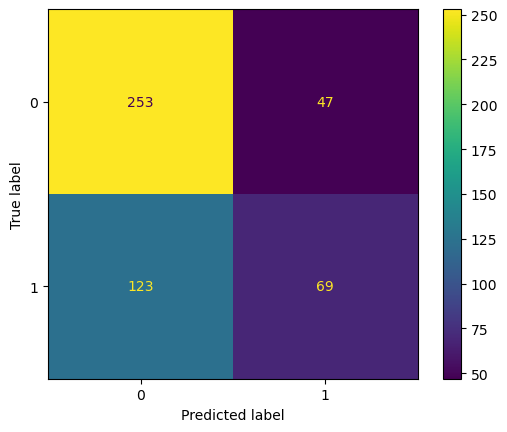

In [59]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_final)

In [60]:
y_test.value_counts()

0    300
1    192
Name: Potability, dtype: int64

In [67]:
69/(69+123)


0.359375

From 192 true potable water in the Test set, the model can only correctly predict 69

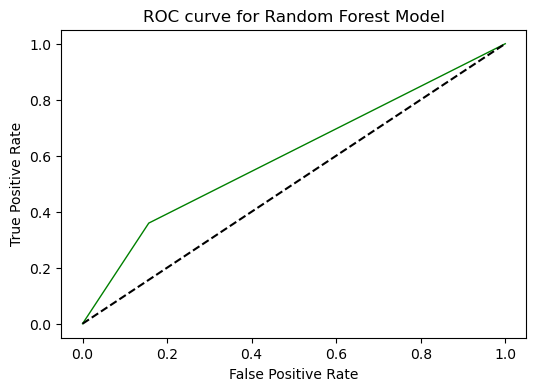

0.6013541666666666


In [61]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf_final)
plt.figure(figsize=(6,4))
plt.plot(fpr,tpr,'-g',linewidth=1)
plt.plot([0,1], [0,1], 'k--' )
plt.title('ROC curve for Random Forest Model')
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')
plt.show();

auc_logreg = metrics.roc_auc_score(y_test, y_pred_rf_final)
print(auc_logreg)

### **6. Conclusion**

- From

In [62]:
# Dump Model to pkl file

filename = 'rf_final_model.pkl'
pickle.dump(rf_tuned, open(filename, 'wb'))